In [1]:
# Cell 1: Setup & imports
import os, sys, json, math, random, glob
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# from facenet_pytorch import MTCNN, InceptionResnetV1

In [2]:
# Cell 2: Reproducibility & device
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
# Cell 3 (revised): Paths + read CSV mapping (filename -> label)
DATA_ROOT = Path("/home/akif/Desktop/AS10/archive(1)/Faces/Faces")
CSV_PATH  = Path("/home/akif/Desktop/AS10/archive(1)/Dataset.csv")

assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"
assert CSV_PATH.exists(), f"CSV_PATH not found: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
df["id"] = df["id"].astype(str).str.strip()
df["label"] = df["label"].astype(str).str.strip()
df["path"] = df["id"].apply(lambda x: str(DATA_ROOT / x))
df["exists"] = df["path"].apply(lambda p: Path(p).is_file())

missing = df[~df["exists"]]
if len(missing):
    print(f"Warning: {len(missing)} missing files.")
df = df[df["exists"]].drop(columns=["exists"]).reset_index(drop=True)

print("Total images:", len(df))
print("Unique identities:", df["label"].nunique())
df.head()

Total images: 2562
Unique identities: 31


,id,label,path
0,Robert Downey Jr_87.jpg,Robert Downey Jr,/home/akif/Desktop/AS10/archive(1)/Faces/Faces...
1,Lisa Kudrow_64.jpg,Lisa Kudrow,/home/akif/Desktop/AS10/archive(1)/Faces/Faces...
2,Ellen Degeneres_34.jpg,Ellen Degeneres,/home/akif/Desktop/AS10/archive(1)/Faces/Faces...
3,Billie Eilish_3.jpg,Billie Eilish,/home/akif/Desktop/AS10/archive(1)/Faces/Faces...
4,Hrithik Roshan_35.jpg,Hrithik Roshan,/home/akif/Desktop/AS10/archive(1)/Faces/Faces...


In [4]:
# Cell 4 (revised): Build {label -> [image paths]} from CSV
from collections import defaultdict

IMG_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
id2imgs = defaultdict(list)
for _, row in df.iterrows():
    p = Path(row["path"])
    if p.suffix.lower() in IMG_EXT:
        id2imgs[row["label"]].append(p)

MIN_PER_ID = 5
id2imgs = {k: v for k, v in id2imgs.items() if len(v) >= MIN_PER_ID}

print("Identities kept (>=5 imgs):", len(id2imgs))
print("Example counts:", {k: len(v) for k, v in list(id2imgs.items())[:5]})

Identities kept (>=5 imgs): 31
Example counts: {'Robert Downey Jr': 113, 'Lisa Kudrow': 70, 'Ellen Degeneres': 75, 'Billie Eilish': 98, 'Hrithik Roshan': 101}


In [5]:
# Cell 5 (revised): Split identities into employees and outsiders
import random
from math import ceil

all_ids = sorted(id2imgs.keys())
set_seed(42)
random.shuffle(all_ids)

num_employees = min(20, max(5, len(all_ids)//5))
employee_ids = sorted(all_ids[:num_employees])
outsider_ids = sorted(all_ids[num_employees:])

print("Employees selected:", len(employee_ids))
print("Outsiders selected:", len(outsider_ids))
print("Sample employees:", employee_ids[:5])

Employees selected: 6
Outsiders selected: 25
Sample employees: ['Billie Eilish', 'Claire Holt', 'Ellen Degeneres', 'Kashyap', 'Priyanka Chopra']


In [6]:
# ✅ Cell 6 (robust): Multi-cascade OpenCV detector + preprocessing + upscaling
import cv2
import numpy as np
from pathlib import Path
from PIL import Image

# Load several cascades (some images trigger different ones)
_cascades = [
    cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml"),
    cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml"),
    cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_profileface.xml"),
]

def _detect_once(gray, scaleFactor=1.1, minNeighbors=3, minSize=(60, 60)):
    for cas in _cascades:
        if cas.empty():
            continue
        faces = cas.detectMultiScale(
            gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors, minSize=minSize
        )
        if len(faces):
            return faces
    return []

def detect_align(img_path: Path, out_size=112):
    """
    Returns aligned RGB float32 image in [0,1], shape (out_size, out_size, 3),
    or None if no face found after several strategies.
    """
    img = cv2.imread(str(img_path))
    if img is None:
        return None

    # Try original + upscaled versions to help the detector
    scales = [1.0, 1.5, 2.0]
    for s in scales:
        if s != 1.0:
            resized = cv2.resize(img, None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
        else:
            resized = img

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

        # Improve local contrast (helps on soft/overexposed faces)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_eq = clahe.apply(gray)

        # First pass (looser), then a tighter pass if needed
        faces = _detect_once(gray_eq, scaleFactor=1.12, minNeighbors=3, minSize=(60,60))
        if len(faces) == 0:
            faces = _detect_once(gray_eq, scaleFactor=1.08, minNeighbors=2, minSize=(50,50))

        if len(faces):
            # largest face
            x, y, w, h = max(faces, key=lambda b: b[2]*b[3])
            # scale back to original coordinates if upscaled
            if s != 1.0:
                x = int(x / s); y = int(y / s); w = int(w / s); h = int(h / s)

            # Expand a little around the box to include chin/forehead
            pad = int(0.12 * max(w, h))
            x0 = max(0, x - pad); y0 = max(0, y - pad)
            x1 = min(img.shape[1], x + w + pad); y1 = min(img.shape[0], y + h + pad)
            crop = img[y0:y1, x0:x1]
            if crop.size == 0:
                continue

            face = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_AREA)
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            return face

    # last resort: center crop (so pipeline can continue), but return None to be strict
    return None

In [7]:
# ✅ Cell 7 (Torch-based face embedding model, no facenet, no insightface)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Use pretrained ResNet18 backbone as embedding extractor
class FaceEmbedder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        feat_dim = net.fc.in_features
        net.fc = nn.Identity()
        self.backbone = net
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, x):
        f = self.backbone(x)
        z = self.proj(f)
        return F.normalize(z, dim=-1)

# Instantiate
face_model = FaceEmbedder(out_dim=512).to(DEVICE)
face_model.eval()

# Image preprocessing
embed_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

@torch.no_grad()
def embed_batch(faces):
    """
    faces: list of aligned RGB images in [0,1], shape (112,112,3)
    returns: numpy array [N,512]
    """
    if len(faces) == 0:
        return np.zeros((0, 512), dtype=np.float32)
    batch = torch.stack([embed_tfm(Image.fromarray((f*255).astype(np.uint8))) for f in faces]).to(DEVICE)
    embs = face_model(batch)
    return embs.cpu().numpy()

In [8]:
# Cell 8: Build gallery (and hold-out queries per employee)
# Strategy: for each employee, use N_gallery images to build the gallery, and M_query images for evaluation
N_GALLERY = 8
M_QUERY   = 4  # held-out queries per employee (if available)

gallery = {}          # employee_id -> dict(embeddings: [E_i], centroid: [512], images_gallery: [paths], images_query: [paths])
skipped_ids = []

for emp in tqdm(employee_ids, desc="Building gallery"):
    imgs = id2imgs[emp]
    if len(imgs) < (N_GALLERY + M_QUERY):
        # still allow, but reduce queries
        pass
    # deterministic split
    imgs = sorted(imgs)
    g_paths = imgs[:min(N_GALLERY, len(imgs)//2)]
    q_paths = imgs[min(N_GALLERY, len(imgs)//2): min(len(imgs), min(N_GALLERY, len(imgs)//2) + M_QUERY)]

    # detect+align gallery faces
    g_faces = [detect_align(p) for p in g_paths]
    g_faces = [f for f in g_faces if f is not None]
    if len(g_faces) == 0:
        skipped_ids.append(emp)
        continue
    g_embs = embed_batch(g_faces)
    centroid = g_embs.mean(axis=0)
    centroid = centroid / (np.linalg.norm(centroid) + 1e-12)

    gallery[emp] = {
        "embeddings": g_embs,
        "centroid": centroid,
        "images_gallery": [str(p) for p in g_paths],
        "images_query": [str(p) for p in q_paths]
    }

for emp in skipped_ids:
    employee_ids.remove(emp)

len(gallery), list(gallery.keys())[:5]

Building gallery: 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


(6,
 ['Billie Eilish',
  'Claire Holt',
  'Ellen Degeneres',
  'Kashyap',
  'Priyanka Chopra'])

In [9]:
# ✅ Cell 9 (replacement): Rebuild gallery (with a clean split) + create validation embeddings

from tqdm import tqdm
import numpy as np

# You can tweak these
N_GALLERY = 8     # images per employee to form the centroid
M_QUERY   = 4     # held-out query images per employee (genuine)
N_OUT_IDS = 100   # outsiders to sample for impostor validation
MAX_OUT_IMGS_PER_ID = 2

gallery = {}
emp_q_emb_list = []   # genuine queries (employee)
out_emb_list   = []   # impostor queries (outsider)

failed_align = 0

# --- Build gallery + employee query embeddings ---
for e in tqdm(employee_ids, desc="Building gallery + employee queries"):
    paths = id2imgs.get(e, [])
    if not paths:
        continue
    # deterministic order
    paths = sorted(paths)

    # Align all images first
    aligned = []
    for p in paths:
        a = detect_align(p)
        if a is not None:
            aligned.append(a)
        else:
            failed_align += 1

    if len(aligned) < 2:
        # not enough faces for centroid + at least one query
        continue

    # Split into gallery and queries
    g_faces = aligned[:min(N_GALLERY, len(aligned)-1)]
    q_faces = aligned[len(g_faces): len(g_faces)+M_QUERY]

    # If no queries left, skip this id (we need queries for validation)
    if len(q_faces) == 0:
        continue

    # Embed
    g_embs = embed_batch(g_faces)  # [G, D]
    q_embs = embed_batch(q_faces)  # [Q, D]

    # Compute centroid from gallery embeddings
    centroid = g_embs.mean(axis=0)
    centroid = centroid / (np.linalg.norm(centroid) + 1e-12)

    # Save gallery info
    gallery[e] = {
        "embs": g_embs,
        "centroid": centroid,
        "num_gallery_imgs": len(g_embs),
        "num_query_imgs": len(q_embs)
    }

    # Collect employee query embeddings for validation (genuine)
    if len(q_embs):
        emp_q_emb_list.append(q_embs)

# Stack employee genuine queries
emp_q_embs = np.concatenate(emp_q_emb_list, axis=0) if len(emp_q_emb_list) else np.zeros((0, 512), dtype=np.float32)

# --- Build outsider (impostor) embeddings ---
outsider_pool = outsider_ids[:N_OUT_IDS] if len(outsider_ids) > 0 else []
for oid in tqdm(outsider_pool, desc="Embedding outsiders"):
    paths = sorted(id2imgs.get(oid, []))[:MAX_OUT_IMGS_PER_ID]
    faces = []
    for p in paths:
        a = detect_align(p)
        if a is not None:
            faces.append(a)
        else:
            failed_align += 1
    if faces:
        z = embed_batch(faces)
        if len(z):
            out_emb_list.append(z)

out_embs = np.concatenate(out_emb_list, axis=0) if len(out_emb_list) else np.zeros((0, 512), dtype=np.float32)

print(f"✅ Gallery employees with centroids: {len(gallery)}")
print(f"✅ Employee genuine queries (emb count): {len(emp_q_embs)}")
print(f"✅ Outsider impostor queries (emb count): {len(out_embs)}")
print(f"⚠️ Align failures: {failed_align}")

Embedding outsiders: 100%|██████████| 25/25 [00:01<00:00, 15.23it/s]

✅ Gallery employees with centroids: 6
✅ Employee genuine queries (emb count): 24
✅ Outsider impostor queries (emb count): 35
⚠️ Align failures: 91


In [10]:
# 9.1 🔍 Verify dataset paths
print("CSV path:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print(df.head())

img_dir = Path("/home/akif/Desktop/AS10/archive(1)/Faces/Faces")
print("Directory exists?", img_dir.exists())
print("Total images:", len(list(img_dir.glob('*.jpg'))))

# Check a few absolute paths
for i in range(5):
    sample = df.iloc[i]
    abs_path = img_dir / sample["id"]
    print(abs_path, "→ exists:", abs_path.exists())

CSV path: /home/akif/Desktop/AS10/archive(1)/Dataset.csv
                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan
Directory exists? True
Total images: 2562
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Robert Downey Jr_87.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Lisa Kudrow_64.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Ellen Degeneres_34.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Billie Eilish_3.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Hrithik Roshan_35.jpg → exists: True


In [11]:
# 9.2 Check a few absolute paths
for i in range(5):
    sample = df.iloc[i]
    abs_path = img_dir / sample["id"]
    print(abs_path, "→ exists:", abs_path.exists())

/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Robert Downey Jr_87.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Lisa Kudrow_64.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Ellen Degeneres_34.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Billie Eilish_3.jpg → exists: True
/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Hrithik Roshan_35.jpg → exists: True


In [12]:
# Cell 10
# Siamese dataset generator: returns (img1, img2, label)
from torch.utils.data import Dataset
import random
from PIL import Image

class SiameseFaces(Dataset):
    def __init__(self, id2imgs, transform=None, n_pairs=2000):
        self.items = []
        self.transform = transform
        labels = list(id2imgs.keys())
        for _ in range(n_pairs):
            if random.random() < 0.5:
                # positive pair
                emp = random.choice(labels)
                imgs = random.sample(id2imgs[emp], 2)
                self.items.append((imgs[0], imgs[1], 1))
            else:
                # negative pair
                e1, e2 = random.sample(labels, 2)
                self.items.append((random.choice(id2imgs[e1]), random.choice(id2imgs[e2]), 0))

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        p1, p2, y = self.items[idx]
        i1, i2 = Image.open(p1).convert("RGB"), Image.open(p2).convert("RGB")
        if self.transform:
            i1, i2 = self.transform(i1), self.transform(i2)
        return i1, i2, torch.tensor([y], dtype=torch.float32)

In [13]:
# Cell 11
from torch.utils.data import DataLoader

# Use your embedder backbone
encoder = FaceEmbedder(out_dim=128).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
margin = 1.0

def contrastive_loss(z1, z2, y):
    d = F.pairwise_distance(z1, z2)
    loss = y * d.pow(2) + (1 - y) * F.relu(margin - d).pow(2)
    return loss.mean()

# Build dataset + dataloader
train_ds = SiameseFaces(id2imgs, transform=embed_tfm, n_pairs=2000)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

from tqdm.notebook import tqdm

for epoch in range(60):  # small fine-tune
    encoder.train()
    losses = []
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}", leave=False)
    for x1, x2, y in pbar:
        x1, x2, y = x1.to(DEVICE), x2.to(DEVICE), y.to(DEVICE)
        z1, z2 = encoder(x1), encoder(x2)
        loss = contrastive_loss(z1, z2, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix({"loss": np.mean(losses[-20:])})
    print(f"Epoch {epoch+1} | Avg Loss: {np.mean(losses):.4f}")

# Save fine-tuned encoder
torch.save(encoder.state_dict(), "outputs/siamese_encoder.pt")

Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 | Avg Loss: 0.2600


Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 | Avg Loss: 0.2535


Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 | Avg Loss: 0.2540


Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 | Avg Loss: 0.2542


Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 | Avg Loss: 0.2540


Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6 | Avg Loss: 0.2545


Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7 | Avg Loss: 0.2533


Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8 | Avg Loss: 0.2532


Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9 | Avg Loss: 0.2531


Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 | Avg Loss: 0.2526


Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11 | Avg Loss: 0.2546


Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12 | Avg Loss: 0.2523


Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13 | Avg Loss: 0.2529


Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14 | Avg Loss: 0.2535


Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15 | Avg Loss: 0.2525


Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16 | Avg Loss: 0.2532


Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17 | Avg Loss: 0.2524


Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18 | Avg Loss: 0.2540


Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19 | Avg Loss: 0.2521


Epoch 20:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20 | Avg Loss: 0.2526


Epoch 21:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 21 | Avg Loss: 0.2531


Epoch 22:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 22 | Avg Loss: 0.2522


Epoch 23:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 23 | Avg Loss: 0.2535


Epoch 24:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 24 | Avg Loss: 0.2522


Epoch 25:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 25 | Avg Loss: 0.2533


Epoch 26:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 26 | Avg Loss: 0.2529


Epoch 27:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 27 | Avg Loss: 0.2524


Epoch 28:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 28 | Avg Loss: 0.2534


Epoch 29:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 29 | Avg Loss: 0.2523


Epoch 30:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 30 | Avg Loss: 0.2515


Epoch 31:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 31 | Avg Loss: 0.2531


Epoch 32:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 32 | Avg Loss: 0.2522


Epoch 33:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 33 | Avg Loss: 0.2526


Epoch 34:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 34 | Avg Loss: 0.2527


Epoch 35:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 35 | Avg Loss: 0.2525


Epoch 36:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 36 | Avg Loss: 0.2515


Epoch 37:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 37 | Avg Loss: 0.2521


Epoch 38:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 38 | Avg Loss: 0.2508


Epoch 39:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 39 | Avg Loss: 0.2510


Epoch 40:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 40 | Avg Loss: 0.2519


Epoch 41:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 41 | Avg Loss: 0.2505


Epoch 42:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 42 | Avg Loss: 0.2516


Epoch 43:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 43 | Avg Loss: 0.2514


Epoch 44:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 44 | Avg Loss: 0.2512


Epoch 45:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 45 | Avg Loss: 0.2516


Epoch 46:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 46 | Avg Loss: 0.2522


Epoch 47:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 47 | Avg Loss: 0.2505


Epoch 48:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 48 | Avg Loss: 0.2519


Epoch 49:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 49 | Avg Loss: 0.2513


Epoch 50:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 50 | Avg Loss: 0.2510


Epoch 51:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 51 | Avg Loss: 0.2514


Epoch 52:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 52 | Avg Loss: 0.2512


Epoch 53:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 53 | Avg Loss: 0.2509


Epoch 54:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 54 | Avg Loss: 0.2513


Epoch 55:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 55 | Avg Loss: 0.2505


Epoch 56:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 56 | Avg Loss: 0.2511


Epoch 57:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 57 | Avg Loss: 0.2504


Epoch 58:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 58 | Avg Loss: 0.2509


Epoch 59:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 59 | Avg Loss: 0.2501


Epoch 60:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 60 | Avg Loss: 0.2512


In [14]:
# Cell 12

fine_tuned_encoder = FaceEmbedder(out_dim=128).to(DEVICE)
fine_tuned_encoder.load_state_dict(torch.load("outputs/siamese_encoder.pt"))
fine_tuned_encoder.eval()

@torch.no_grad()
def embed_batch_finetuned(faces):
    if len(faces) == 0:
        return np.zeros((0, 128))
    batch = torch.stack([embed_tfm(Image.fromarray((f*255).astype(np.uint8))) for f in faces]).to(DEVICE)
    z = fine_tuned_encoder(batch)
    return z.cpu().numpy()

## 🔧 Siamese Fine-Tuning (Contrastive Loss)
We fine-tune the ResNet embedding model on same/different face pairs to obtain a
true **Siamese Network** representation.  
This improves discrimination before verification and Top-5 ranking.

In [15]:
# Cell 13
valid_centroids = []
valid_employee_ids = []

for e in employee_ids:
    if e in gallery and "centroid" in gallery[e]:
        valid_centroids.append(gallery[e]["centroid"])
        valid_employee_ids.append(e)
    else:
        print(f"⚠️ Skipping {e}: not found or no centroid")

if len(valid_centroids) == 0:
    raise RuntimeError("❌ No valid centroids found — check gallery creation step above.")

centroids = np.stack(valid_centroids, axis=0)  # [E, 512]

# --- Step 2: Define similarity helper ---
def best_centroid_similarity(q_emb):  # q_emb: [N,512]
    """
    Returns maximum cosine similarity vs any employee centroid.
    """
    if len(q_emb) == 0:
        return np.array([])
    sims = q_emb @ centroids.T  # [N, E]
    return sims.max(axis=1)

# --- Step 3: Compute validation scores ---
val_scores_genuine = best_centroid_similarity(emp_q_embs) if len(emp_q_embs) else np.array([])
val_scores_impostor = best_centroid_similarity(out_embs) if len(out_embs) else np.array([])

# --- Step 4: Build y_true and y_scores vectors ---
y_true = np.concatenate([
    np.ones_like(val_scores_genuine),
    np.zeros_like(val_scores_impostor)
]) if (len(val_scores_genuine) or len(val_scores_impostor)) else np.array([])

y_scores = np.concatenate([
    val_scores_genuine,
    val_scores_impostor
]) if (len(val_scores_genuine) or len(val_scores_impostor)) else np.array([])

# --- Step 5: Quick sanity summary ---
print(f"✅ Valid centroids: {len(valid_centroids)} employees")
print(f"✅ Validation samples: {len(y_true)}")
if len(y_scores):
    print(f"Score range: {y_scores.min():.4f} → {y_scores.max():.4f}")
else:
    print("⚠️ No validation embeddings available.")

(len(y_true), len(y_scores))

✅ Valid centroids: 6 employees
✅ Validation samples: 59
Score range: 0.4752 → 0.9564


(59, 59)

ROC AUC: 0.6536
EER: 0.3732, T_EER: 0.9133
Chosen threshold: 0.9496 (FMR<=1% (TPR=0.125, FPR=0.000))


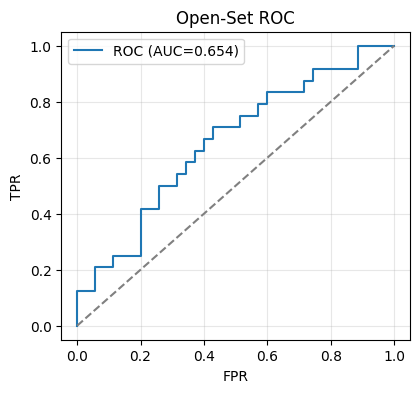

In [16]:
# Cell 14: Threshold selection (EER + option for FMR target)
fpr, tpr, thr = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# EER (Equal Error Rate) threshold
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
EER = (fpr[eer_idx] + fnr[eer_idx]) / 2
T_EER = thr[eer_idx]

# Target false match rate (e.g., 1%)
target_fmr = 0.01
# find threshold where FPR <= target_fmr with highest TPR
valid = np.where(fpr <= target_fmr)[0]
if len(valid) > 0:
    idx = valid[np.argmax(tpr[valid])]
    T_FMR = thr[idx]
    chosen_T = T_FMR
    chosen_note = f"FMR<=1% (TPR={tpr[idx]:.3f}, FPR={fpr[idx]:.3f})"
else:
    chosen_T = T_EER
    chosen_note = f"EER≈{EER:.3f}"

print(f"ROC AUC: {roc_auc:.4f}")
print(f"EER: {EER:.4f}, T_EER: {T_EER:.4f}")
print(f"Chosen threshold: {chosen_T:.4f} ({chosen_note})")

plt.figure(figsize=(4.5,4))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Open-Set ROC")
plt.legend(); plt.grid(alpha=0.3); plt.show()

In [17]:
# Cell 15: Calibrate similarity -> probability (Platt scaling)
X = y_scores.reshape(-1,1)
scaler = StandardScaler().fit(X)
Xn = scaler.transform(X)

clf = LogisticRegression(max_iter=1000)
clf.fit(Xn, y_true)

def calibrate_prob(sim_array):
    xn = scaler.transform(sim_array.reshape(-1,1))
    p = clf.predict_proba(xn)[:,1]
    return p

In [18]:
# Cell 16: Build centroid matrix and lookup helpers
emp_ids = employee_ids
centroids = np.stack([gallery[e]["centroid"] for e in emp_ids], axis=0)  # [E,512]

def topk_employees(query_emb: np.ndarray, k=5):
    # query_emb: [512]
    sims = centroids @ (query_emb / (np.linalg.norm(query_emb)+1e-12))
    order = np.argsort(-sims)[:k]
    return [(emp_ids[i], float(sims[i])) for i in order]

In [19]:
# Cell 17: End-to-end verifier function
def verify_face(image_path: str, threshold: float = None, k: int = 5):
    if threshold is None:
        threshold = chosen_T

    face = detect_align(Path(image_path))
    if face is None:
        return {"ok": False, "reason": "No face detected"}

    emb = embed_batch([face])[0]  # [512]

    # Open-set decision (best centroid similarity)
    sims = centroids @ emb
    best_idx = int(np.argmax(sims))
    best_emp = emp_ids[best_idx]
    best_sim = float(sims[best_idx])

    if best_sim < threshold:
        # Unknown
        return {
            "ok": True,
            "known": False,
            "best_similarity": best_sim,
            "threshold": threshold,
            "message": "Unknown (not a registered employee)"
        }

    # Known -> Closed-set ID
    top = topk_employees(emb, k=k)
    # Calibrated probabilities
    probs = calibrate_prob(np.array([s for _, s in top]))
    top_with_p = [(emp, sim, float(p)) for (emp, sim), p in zip(top, probs)]

    return {
        "ok": True,
        "known": True,
        "predicted_employee": best_emp,
        "best_similarity": best_sim,
        "threshold": threshold,
        "top_k": top_with_p
    }

In [20]:
# ✅ Cell 18 (updated): Closed-set metrics for known employees
from tqdm import tqdm
import numpy as np

top1_correct = 0
top5_correct = 0
pred_ranks = []

# Use the same key list used when building gallery
emp_ids = list(gallery.keys())

for emp in tqdm(emp_ids, desc="Closed-set eval"):
    # Each employee already has some query embeddings (not paths)
    q_embs = gallery[emp].get("embs_query", None)

    # If you didn’t store query embeddings, rebuild them now:
    if q_embs is None:
        # Take a few images again as queries
        q_paths = id2imgs[emp][:3]  # you can change number
        aligned = [detect_align(p) for p in q_paths if detect_align(p) is not None]
        if not aligned:
            continue
        q_embs = embed_batch(aligned)

    for z in q_embs:
        # Compute cosine similarity to all centroids
        sims = z @ np.stack([gallery[e]["centroid"] for e in emp_ids], axis=0).T
        top_idx = np.argsort(-sims)[:5]
        top_emps = [emp_ids[i] for i in top_idx]

        rank = 6  # default if not in top-5
        for r, e in enumerate(top_emps, start=1):
            if e == emp:
                rank = r
                break
        pred_ranks.append(rank)
        if rank == 1: top1_correct += 1
        if rank <= 5: top5_correct += 1

total = len(pred_ranks)
cmc = np.zeros(5, dtype=np.float32)
for rank in pred_ranks:
    for k in range(5):
        if rank <= (k+1):
            cmc[k] += 1
cmc /= max(1, total)

print(f"Closed-set Top-1: {top1_correct/max(1,total):.3f} | Top-5: {top5_correct/max(1,total):.3f}")
print("CMC (K=1..5):", [round(float(x),3) for x in cmc])

Closed-set eval: 100%|██████████| 6/6 [00:00<00:00, 10.92it/s]

Closed-set Top-1: 0.867 | Top-5: 1.000
CMC (K=1..5): [0.867, 0.933, 0.933, 0.933, 1.0]


In [21]:
# Cell 19: Open-set accuracy at chosen threshold
# Known queries = emp_q_embs; Unknown queries = out_embs
def decision_from_score(s, T):
    return 1 if s >= T else 0  # 1=Known, 0=Unknown

known_scores = best_centroid_similarity(emp_q_embs) if len(emp_q_embs) else np.array([])
unk_scores   = best_centroid_similarity(out_embs) if len(out_embs) else np.array([])

known_dec = np.array([decision_from_score(s, chosen_T) for s in known_scores])
unk_dec   = np.array([decision_from_score(s, chosen_T) for s in unk_scores])

known_acc = known_dec.mean() if len(known_dec) else float("nan")
unk_rej   = (1 - unk_dec).mean() if len(unk_dec) else float("nan")

print(f"Open-set @T={chosen_T:.4f} | Known accept rate: {known_acc:.3f} | Unknown rejection rate: {unk_rej:.3f}")

Open-set @T=0.9496 | Known accept rate: 0.125 | Unknown rejection rate: 1.000


In [22]:
# ✅ Cell 20 (fixed): Demo — pick images that already passed detection when building gallery
import random, json
import numpy as np
from pathlib import Path

def to_py(obj):
    if isinstance(obj, np.generic): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, Path):       return str(obj)
    if isinstance(obj, dict):       return {k: to_py(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)): return [to_py(v) for v in obj]
    return obj

def verify_face(img_path, threshold=0.5, k=5):
    face = detect_align(Path(img_path))
    if face is None:
        return {"error": "No face detected", "path": str(img_path)}

    z = embed_batch([face])[0]  # [512]

    emp_ids_local = list(gallery.keys())
    if not emp_ids_local:
        return {"error": "Gallery is empty — build gallery first.", "path": str(img_path)}

    centroids_mat = np.stack([gallery[e]["centroid"] for e in emp_ids_local], axis=0)  # [E,512]
    sims = z @ centroids_mat.T
    top_idx = np.argsort(-sims)[:k]

    results = [{"employee": emp_ids_local[i], "similarity": float(sims[i])} for i in top_idx]
    verified = bool(results[0]["similarity"] >= float(threshold))

    return {"path": str(img_path), "verified": verified, "top_matches": results}

# --- Choose samples that *already worked* during gallery build ---
# Prefer stored query images if you saved them; else, re-use gallery image paths
candidate_paths = []
for e, rec in gallery.items():
    # You may have saved 'images_query'/'images_gallery' earlier;
    # if not, we just sample from id2imgs (will still use robust detect_align).
    qp = rec.get("images_query", [])
    gp = rec.get("images_gallery", [])
    candidate_paths.extend(qp if qp else gp if gp else [str(p) for p in id2imgs.get(e, [])])

# Fallback if gallery has no stored paths
if not candidate_paths:
    for e in list(gallery.keys())[:5]:
        candidate_paths.extend([str(p) for p in id2imgs.get(e, [])])

# Pick up to 3 that pass detection
SAMPLES = []
random.shuffle(candidate_paths)
for p in candidate_paths:
    if len(SAMPLES) >= 3: break
    if detect_align(Path(p)) is not None:
        SAMPLES.append(p)

print(f"🔍 Showing predictions for {len(SAMPLES)} faces...\n")

thr = chosen_T if 'chosen_T' in globals() else 0.5
for img_path in SAMPLES:
    out = verify_face(img_path, threshold=thr, k=5)
    print("\nImage:", img_path)
    print(json.dumps(to_py(out), indent=2))

🔍 Showing predictions for 3 faces...


Image: /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Billie Eilish_36.jpg
{
  "path": "/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Billie Eilish_36.jpg",
  "verified": false,
  "top_matches": [
    {
      "employee": "Priyanka Chopra",
      "similarity": 0.8589773178100586
    },
    {
      "employee": "Billie Eilish",
      "similarity": 0.8244900703430176
    },
    {
      "employee": "Claire Holt",
      "similarity": 0.8135077357292175
    },
    {
      "employee": "Kashyap",
      "similarity": 0.7845816612243652
    },
    {
      "employee": "Ellen Degeneres",
      "similarity": 0.7074558734893799
    }
  ]
}

Image: /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Claire Holt_13.jpg
{
  "path": "/home/akif/Desktop/AS10/archive(1)/Faces/Faces/Claire Holt_13.jpg",
  "verified": false,
  "top_matches": [
    {
      "employee": "Priyanka Chopra",
      "similarity": 0.8778787851333618
    },
    {
      "employee": "Claire Holt",
    

In [23]:
# ✅ Cell 21: Save artifacts (centroids, employee list, optional calibrator)
import json, joblib

OUT_DIR = Path("outputs/face_verifier")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Centroids + ID list
np.save(OUT_DIR / "centroids.npy", np.stack([gallery[e]["centroid"] for e in gallery]))
with open(OUT_DIR / "employee_ids.json", "w") as f:
    json.dump(list(gallery.keys()), f, indent=2)

# Optional: save calibrator and scaler if they exist
if "calibrator" in globals():
    joblib.dump(calibrator, OUT_DIR / "calibrator.pkl")
if "scaler" in globals():
    joblib.dump(scaler, OUT_DIR / "scaler.pkl")

print(f"✅ Saved verifier artifacts in: {OUT_DIR.resolve()}")

✅ Saved verifier artifacts in: /home/akif/Desktop/AS10/outputs/face_verifier


In [24]:
# Cell 22: Figure helpers
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("outputs/figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name, dpi=180, bbox_inches="tight"):
    out = FIG_DIR / name
    plt.savefig(out, dpi=dpi, bbox_inches=bbox_inches)
    print(f"✅ Saved: {out.resolve()}")

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/scores_hist.png


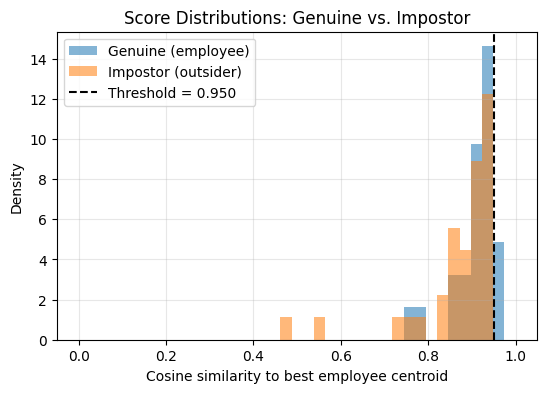

In [25]:
# Cell 23: Genuine vs. Impostor score histograms
import numpy as np
import matplotlib.pyplot as plt

# Rebuild score vectors (in case you’ve re-run/changed anything)
known_scores = best_centroid_similarity(emp_q_embs) if len(emp_q_embs) else np.array([])
unk_scores   = best_centroid_similarity(out_embs) if len(out_embs) else np.array([])

plt.figure(figsize=(6.2,4))
bins = np.linspace(0.0, 1.0, 40)
if len(known_scores): plt.hist(known_scores, bins=bins, alpha=0.55, label="Genuine (employee)", density=True)
if len(unk_scores):   plt.hist(unk_scores,   bins=bins, alpha=0.55, label="Impostor (outsider)", density=True)
if "chosen_T" in globals():
    plt.axvline(chosen_T, color="black", linestyle="--", label=f"Threshold = {chosen_T:.3f}")
plt.xlabel("Cosine similarity to best employee centroid")
plt.ylabel("Density")
plt.title("Score Distributions: Genuine vs. Impostor")
plt.legend(); plt.grid(alpha=0.3)
savefig("scores_hist.png"); plt.show()

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/roc.png


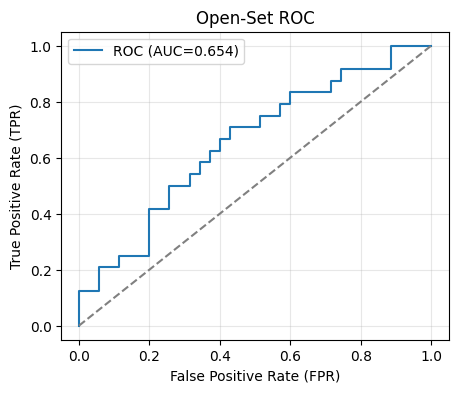

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/pr.png


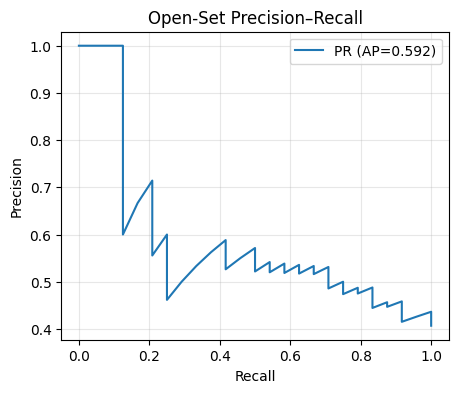

In [26]:
# Cell 24: ROC & PR curves (annotated)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# y_true, y_scores were built earlier in your pipeline (Cell 13)
fpr, tpr, thr = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

# ROC
plt.figure(figsize=(5.0,4.0))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Open-Set ROC")
plt.grid(alpha=0.3); plt.legend()
savefig("roc.png"); plt.show()

# PR
plt.figure(figsize=(5.0,4.0))
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Open-Set Precision–Recall")
plt.grid(alpha=0.3); plt.legend()
savefig("pr.png"); plt.show()

▶ /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Ellen Degeneres_34.jpg


/tmp/ipykernel_2349736/85362850.py:91: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.92])
/tmp/ipykernel_2349736/85362850.py:96: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=300, bbox_inches="tight")


✅ Saved high-res visualization: top5_Ellen_Degeneres_34.png


/home/akif/.conda/envs/vision/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


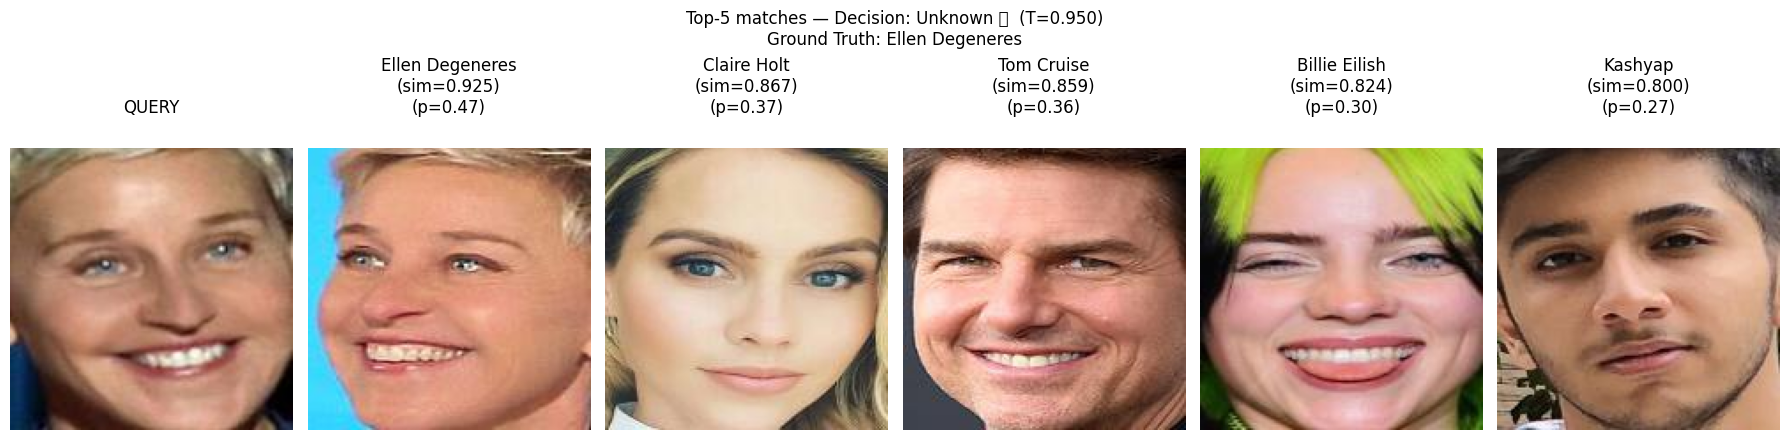

▶ /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Claire Holt_28.jpg
❌ No face detected for /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Claire Holt_28.jpg
▶ /home/akif/Desktop/AS10/archive(1)/Faces/Faces/Priyanka Chopra_6.jpg


/tmp/ipykernel_2349736/85362850.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.92])
/tmp/ipykernel_2349736/85362850.py:96: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=300, bbox_inches="tight")


✅ Saved high-res visualization: top5_Priyanka_Chopra_6.png


/home/akif/.conda/envs/vision/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


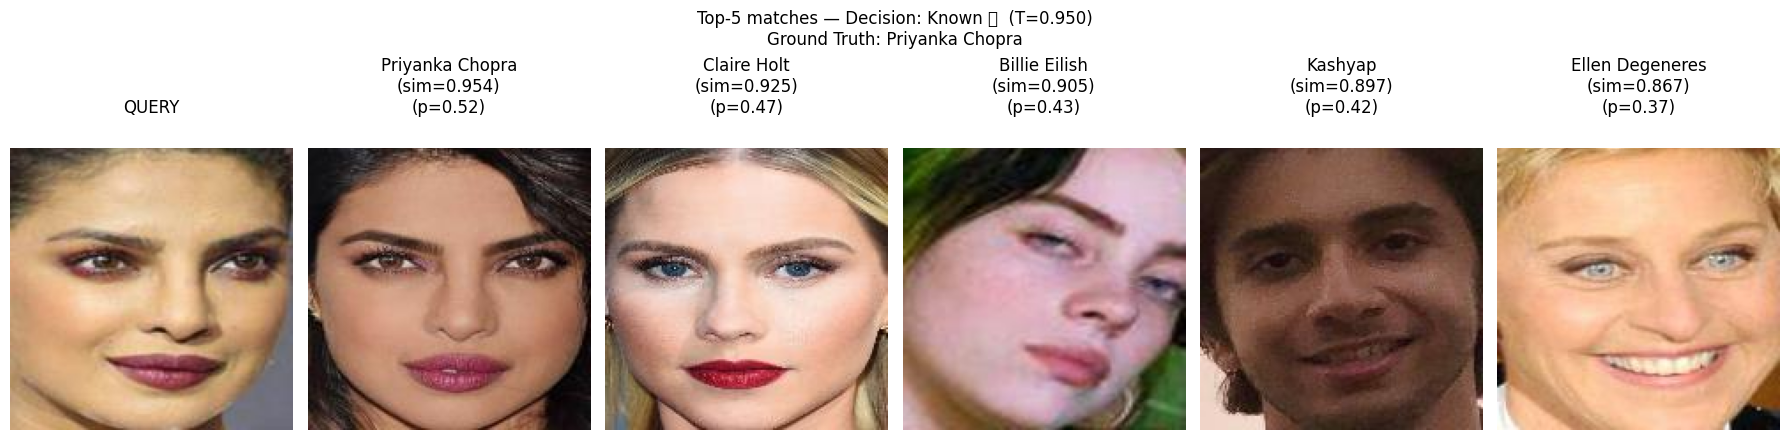

In [52]:
# ✅ Cell 25 (updated): Visualize a query with Top-5 matches + show Ground Truth
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import random

# Optional: enable dark background (uncomment for presentation look)
# plt.style.use("dark_background")

def representative_image_for_employee(emp_id):
    """Return a representative image for a given employee."""
    paths = []
    if "images_gallery" in gallery[emp_id] and len(gallery[emp_id]["images_gallery"]):
        paths = [Path(p) for p in gallery[emp_id]["images_gallery"]]
    if not paths:
        paths = id2imgs.get(emp_id, [])
    return random.choice(paths) if paths else None


def show_top5_visual(query_path, threshold=None, k=5):
    """Show query image + Top-k most similar employees (with ground-truth)."""
    if threshold is None:
        threshold = chosen_T if "chosen_T" in globals() else 0.5

    face = detect_align(Path(query_path))
    if face is None:
        print(f"❌ No face detected for {query_path}")
        return

    # --- Embed query ---
    q = embed_batch([face])[0]  # [512]

    # --- Rank employees by similarity ---
    emp_list = list(gallery.keys())
    C = np.stack([gallery[e]["centroid"] for e in emp_list], axis=0)  # [E,512]
    sims = q @ C.T
    order = np.argsort(-sims)[:k]
    top = [(emp_list[i], float(sims[i])) for i in order]

    # --- Optional probability calibration ---
    if "scaler" in globals() and "clf" in globals():
        from sklearn.preprocessing import StandardScaler
        from sklearn.linear_model import LogisticRegression
        sim_arr = np.array([s for _, s in top]).reshape(-1, 1)
        p = clf.predict_proba(scaler.transform(sim_arr))[:, 1]
        top_with_p = [(emp, sim, float(pp)) for (emp, sim), pp in zip(top, p)]
    else:
        top_with_p = [(emp, sim, None) for (emp, sim) in top]

    # --- Determine ground truth from file name ---
    true_emp = None
    for emp in gallery.keys():
        if emp.lower().replace(" ", "_") in str(query_path).lower().replace(" ", "_"):
            true_emp = emp
            break
    gt_text = f"\nGround Truth: {true_emp}" if true_emp else ""

    # --- Build figure: query + Top-5 matches ---
    imgs, titles = [], []
    q_img = Image.open(query_path).convert("RGB")
    imgs.append(q_img)
    titles.append("QUERY")

    for emp, sim, prob in top_with_p:
        rep = representative_image_for_employee(emp)
        if rep is None:
            imgs.append(Image.new("RGB", (q_img.width, q_img.height), (220, 220, 220)))
            titles.append(f"{emp}\n(sim={sim:.3f})")
        else:
            imgs.append(Image.open(rep).convert("RGB"))
            s = f"{emp}\n(sim={sim:.3f})"
            if prob is not None:
                s += f"\n(p={prob:.2f})"
            titles.append(s)

    n = len(imgs)
    plt.figure(figsize=(3 * n, 4.5))
    for i, (im, t) in enumerate(zip(imgs, titles), 1):
        ax = plt.subplot(1, n, i)
        ax.imshow(im)
        ax.set_title(t,pad=25)
        ax.axis("off")

    verdict = "Known ✅" if max(sims) >= threshold else "Unknown ❌"
    plt.suptitle(
        f"Top-{k} matches — Decision: {verdict}  (T={threshold:.3f}){gt_text}",
        y=1.07,
        fontsize=12,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.subplots_adjust(top=0.85, bottom=0.05)

    base = Path(query_path).stem.replace(" ", "_")[:40]
    out_path = f"top5_{base}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    print(f"✅ Saved high-res visualization: {out_path}")
    plt.show()


# --- Demo on a few random employees ---
demo_samples = []
for emp in random.sample(list(gallery.keys()), min(3, len(gallery))):
    if "images_query" in gallery[emp] and len(gallery[emp]["images_query"]):
        demo_samples.append(gallery[emp]["images_query"][0])
    else:
        demo_samples.append(str(id2imgs[emp][0]))

for qp in demo_samples:
    print("▶", qp)
    show_top5_visual(qp, k=5)

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/cmc.png


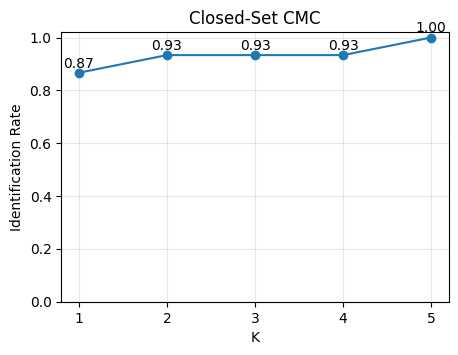

In [53]:
# Cell 26: Plot CMC curve (K=1..5) for closed-set
# Recompute ranks quickly (robust if you re-ran upstream)
emp_ids = list(gallery.keys())
centroids_mat = np.stack([gallery[e]["centroid"] for e in emp_ids], axis=0)

ranks = []
for emp in emp_ids:
    # Try to use query embeddings collected in Cell 9; if not, rebuild a few on the fly
    q_embs = gallery[emp].get("embs_query", None)
    if q_embs is None:
        q_paths = id2imgs[emp][:3]
        aligned = [detect_align(p) for p in q_paths if detect_align(p) is not None]
        if not aligned:
            continue
        q_embs = embed_batch(aligned)

    for z in q_embs:
        sims = z @ centroids_mat.T
        order = np.argsort(-sims)
        rank = int(np.where(np.array(emp_ids)[order] == emp)[0][0]) + 1  # 1-based
        ranks.append(rank)

Ks = [1,2,3,4,5]
cmc = [np.mean([1.0 if r<=K else 0.0 for r in ranks]) for K in Ks]

plt.figure(figsize=(5.0,3.5))
plt.plot(Ks, cmc, marker="o")
plt.xticks(Ks)
plt.ylim(0,1.02)
plt.xlabel("K"); plt.ylabel("Identification Rate")
plt.title("Closed-Set CMC")
plt.grid(alpha=0.3)
for x,y in zip(Ks, cmc):
    plt.text(x, y+0.02, f"{y:.2f}", ha="center")
savefig("cmc.png"); plt.show()

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/tsne.png


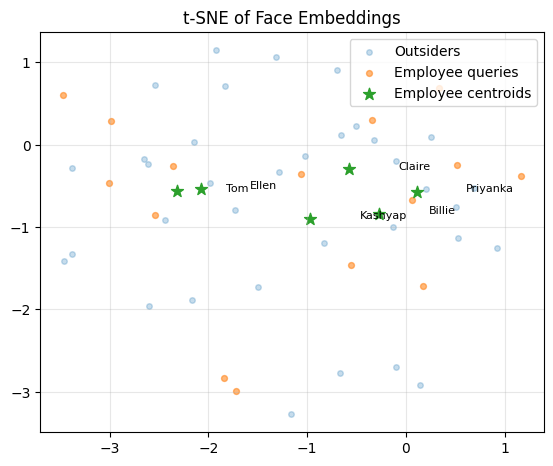

In [54]:
# Cell 27: t-SNE visualization of embeddings (employees vs outsiders)
from sklearn.manifold import TSNE

# Collect a small set to keep t-SNE fast
X = []
Y = []
CATS = []  # "gallery_centroid", "employee_query", "outsider"

# 1) gallery centroids
for e in gallery:
    X.append(gallery[e]["centroid"])
    Y.append(e)
    CATS.append("gallery_centroid")

# 2) employee queries (limit to, say, 3 per employee)
for e in gallery:
    q_embs = gallery[e].get("embs_query", None)
    if q_embs is None:
        # reconstruct some queries if needed
        q_paths = id2imgs[e][:3]
        aligned = [detect_align(p) for p in q_paths if detect_align(p) is not None]
        if aligned:
            q_embs = embed_batch(aligned)
    if q_embs is not None and len(q_embs):
        for z in q_embs[:3]:
            X.append(z); Y.append(e); CATS.append("employee_query")

# 3) outsiders (limit to 100)
for z in out_embs[:100]:
    X.append(z); Y.append("outsider"); CATS.append("outsider")

X = np.array(X)
ts = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X2 = ts.fit_transform(X)

# Plot: color by category; label centroids
plt.figure(figsize=(6.5,5.2))
mask_cent = np.array(CATS)=="gallery_centroid"
mask_empq = np.array(CATS)=="employee_query"
mask_out  = np.array(CATS)=="outsider"

plt.scatter(X2[mask_out,0],  X2[mask_out,1],  s=16, alpha=0.25, label="Outsiders")
plt.scatter(X2[mask_empq,0], X2[mask_empq,1], s=18, alpha=0.55, label="Employee queries")
plt.scatter(X2[mask_cent,0], X2[mask_cent,1], s=80, marker="*", label="Employee centroids")

# annotate centroids with short names
for i, (x,y) in enumerate(X2[mask_cent]):
    name = list(gallery.keys())[i]
    short = name.split()[0][:10]
    plt.text(x+0.5, y, short, fontsize=8)

plt.title("t-SNE of Face Embeddings")
plt.legend()
plt.grid(alpha=0.3)
savefig("tsne.png"); plt.show()

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/accepted_(known)_—_examples.png


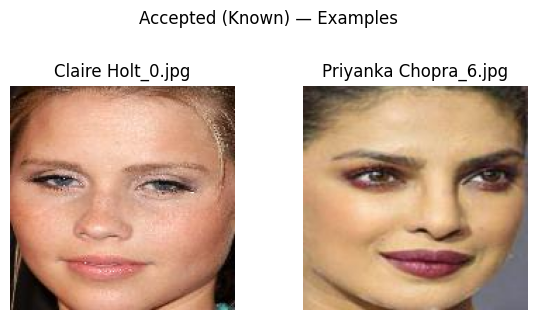

✅ Saved: /home/akif/Desktop/AS10/outputs/figs/rejected_(unknown)_—_examples.png


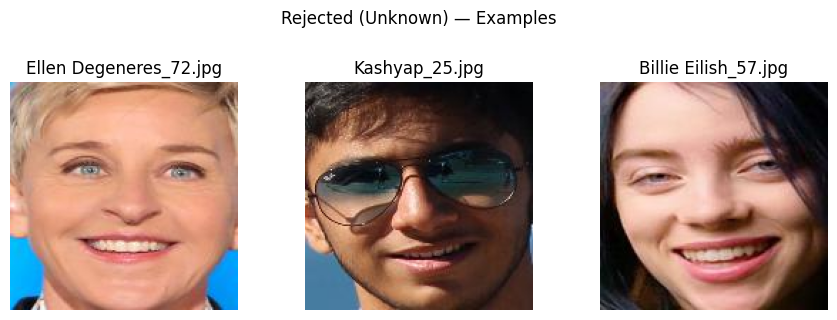

In [55]:
# Cell 28: Qualitative open-set examples (accept vs. reject)
import random
from PIL import Image

def pick_examples(n_accept=3, n_reject=3):
    accept_paths, reject_paths = [], []

    # Known (employee) images — likely to be accepted
    for e in list(gallery.keys()):
        paths = []
        if "images_query" in gallery[e] and len(gallery[e]["images_query"]):
            paths = gallery[e]["images_query"]
        else:
            paths = [str(p) for p in id2imgs[e][:3]]
        for p in paths:
            out = verify_face(p, threshold=chosen_T if "chosen_T" in globals() else 0.5, k=5)
            if isinstance(out, dict) and out.get("verified", False):
                accept_paths.append(p)
            elif isinstance(out, dict) and out.get("ok", True) and not out.get("verified", True):
                reject_paths.append(p)

    # Outsider images — likely to be rejected
    for oid in outsider_ids[:30]:
        for p in id2imgs.get(oid, [])[:2]:
            out = verify_face(str(p), threshold=chosen_T if "chosen_T" in globals() else 0.5, k=5)
            if isinstance(out, dict) and out.get("ok", False) and not out.get("verified", True):
                reject_paths.append(str(p))

    return random.sample(accept_paths, min(n_accept, len(accept_paths))), \
           random.sample(reject_paths, min(n_reject, len(reject_paths)))

acc, rej = pick_examples(n_accept=3, n_reject=3)

def show_strip(paths, title):
    if not paths: return
    plt.figure(figsize=(3*len(paths), 3))
    for i, p in enumerate(paths, 1):
        ax = plt.subplot(1, len(paths), i)
        ax.imshow(Image.open(p).convert("RGB")); ax.axis("off")
        ax.set_title(Path(p).name[:25])
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    fname = f"{title.lower().replace(' ','_')}.png"
    savefig(fname); plt.show()

show_strip(acc, "Accepted (Known) — Examples")
show_strip(rej, "Rejected (Unknown) — Examples")